## PAMAPS database analysis and statistics

In [2]:
# basic
import os 
import sys
import math
from time import time
import pickle

# general
import warnings
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# notebook
from IPython.display import display

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , roc_auc_score , confusion_matrix , f1_score
from sklearn import metrics

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Linear
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam,SGD , RMSprop

import gc


from tqdm import tqdm
import copy  # to save best model parameters


**Subject participating in the experiment were asked to perform activities from the list below. Some were optional.\
In practice, there were only 12 activities performed.**

In [3]:
load_activity_map = {}
load_activity_map[0] = 'transient'
load_activity_map[1] = 'lying'
load_activity_map[2] = 'sitting'
load_activity_map[3] = 'standing'
load_activity_map[4] = 'walking'
load_activity_map[5] = 'running'
load_activity_map[6] = 'cycling'
load_activity_map[7] = 'Nordic_walking'
load_activity_map[9] = 'watching_TV'
load_activity_map[10] = 'computer_work'
load_activity_map[11] = 'car driving'
load_activity_map[12] = 'ascending_stairs'
load_activity_map[13] = 'descending_stairs'
load_activity_map[16] = 'vacuum_cleaning'
load_activity_map[17] = 'ironing'
load_activity_map[18] = 'folding_laundry'
load_activity_map[19] = 'house_cleaning'
load_activity_map[20] = 'playing_soccer'
load_activity_map[24] = 'rope_jumping'

**We upload the data from all sensors. These included:\
•	3 IMUs (Internal measurements units) with 100Hz sampling rate. One IMU over the wrist of the dominant arm, one IMU on the chest and one IMU on the dominant side's ankle . Each sensory data contains the following information:**

o	Temperature (°C)\
o	3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit\
o	3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit\
o	3D-gyroscope data (rad/s)\
o	3D-magnetometer data (μT)\
o	orientation (invalid in this data collection)\

•	**HR-monitor (heart rate) with sampling rate of 9Hz**

The paper only used the data of the ±16g range accelerometer, gyroscope and magnetometer on the ankle, chest and hand

In [4]:
Data_dir = "./PAMAP2_Dataset/Protocol/"

### loading the data

In [5]:
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]

def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]

def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_accelerometer_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_accelerometer_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output
    
def load_subjects(root=Data_dir+'subject'):
    output = pd.DataFrame()
    cols = load_IMU()
    
    for i in range(101,110):
        print ("Loading subject number: {}",format(i))
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols 
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects()

Loading subject number: {} 101


C:\Users\AYALAR~1\AppData\Local\Temp/ipykernel_18568/520853857.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)


Loading subject number: {} 102


C:\Users\AYALAR~1\AppData\Local\Temp/ipykernel_18568/520853857.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)


Loading subject number: {} 103


C:\Users\AYALAR~1\AppData\Local\Temp/ipykernel_18568/520853857.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)


Loading subject number: {} 104


C:\Users\AYALAR~1\AppData\Local\Temp/ipykernel_18568/520853857.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)


Loading subject number: {} 105


C:\Users\AYALAR~1\AppData\Local\Temp/ipykernel_18568/520853857.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)


Loading subject number: {} 106


C:\Users\AYALAR~1\AppData\Local\Temp/ipykernel_18568/520853857.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)


Loading subject number: {} 107


C:\Users\AYALAR~1\AppData\Local\Temp/ipykernel_18568/520853857.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)


Loading subject number: {} 108


C:\Users\AYALAR~1\AppData\Local\Temp/ipykernel_18568/520853857.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)


Loading subject number: {} 109


C:\Users\AYALAR~1\AppData\Local\Temp/ipykernel_18568/520853857.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)


In [6]:
data.shape

(2872533, 55)

In [7]:
data.head(10)

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_accelerometer_16_x,hand_3D_accelerometer_16_y,hand_3D_accelerometer_16_z,hand_3D_accelerometer_6_x,hand_3D_accelerometer_6_y,hand_3D_accelerometer_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,101
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,101
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,101
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,101
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,101
5,8.43,0,NaN,30.0,2.29959,8.82929,3.54710,2.26132,8.65762,3.77788,...,-0.016024,0.001050,-60.2954,-38.8778,-58.3977,1.0,0.0,0.0,0.0,101
6,8.44,0,NaN,30.0,2.33738,8.82900,3.54767,2.27703,8.77828,3.73230,...,-0.053934,0.015594,-60.6307,-38.8676,-58.2711,1.0,0.0,0.0,0.0,101
7,8.45,0,NaN,30.0,2.37142,9.05500,3.39347,2.39786,8.89814,3.64131,...,-0.039937,-0.000785,-60.5171,-38.9819,-58.2733,1.0,0.0,0.0,0.0,101
8,8.46,0,NaN,30.0,2.33951,9.13251,3.54668,2.44371,8.98841,3.62596,...,-0.010042,0.017701,-61.2916,-39.6182,-58.1499,1.0,0.0,0.0,0.0,101
9,8.47,0,NaN,30.0,2.25966,9.09415,3.43015,2.42877,9.01871,3.61081,...,-0.013923,0.014498,-60.8509,-39.0821,-58.1478,1.0,0.0,0.0,0.0,101


### Data cleaning

We see that there are a lot of label 0 for transient activity - not a true label.\
We remove all of these instances.

To fix potential issues of None values, we interpolate the data (although this is relevant to sensors that are not considered in the model)

In [8]:
# percentage of lables that are not interesting 
Interesting_lables_per = np.count_nonzero(data['activity_id'] == 0) / data.shape[0]
print (Interesting_lables_per)

0.32363805742179463


In [9]:
# Dealing with NAN and removing activity = 0
def fix_data(data):
    data = data.drop(data[data['activity_id']==0].index)
    data = data.interpolate()
    return data

data = fix_data(data)

In [10]:
print('total number of NaN values after interpolation',data.isna().sum().sum())
print('Number of NaN values in heart_rate column',data['heart_rate'].isna().sum())
print('So all NaNs are in heart_rate')

total number of NaN values after interpolation 4
Number of NaN values in heart_rate column 4
So all NaNs are in heart_rate


### General statistics

In [11]:
print('Size of the data: ', data.size)
print('Shape of the data: ', data.shape)
print('Number of columns in the data: ', len(data.columns))
result_id = data.groupby(['id']).mean().reset_index()
print('Number of unique ids in the data: ', len(result_id))
result_act = data.groupby(['activity_id']).mean().reset_index()
print('Numbe of unique activitys in the data: ',len(result_act))

Size of the data:  106857960
Shape of the data:  (1942872, 55)
Number of columns in the data:  55
Number of unique ids in the data:  9
Numbe of unique activitys in the data:  12


In [12]:
data.describe()

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_accelerometer_16_x,hand_3D_accelerometer_16_y,hand_3D_accelerometer_16_z,hand_3D_accelerometer_6_x,hand_3D_accelerometer_6_y,hand_3D_accelerometer_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
count,1.942872e+06,1.942872e+06,1.942868e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,...,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06
mean,1.705202e+03,8.081830e+00,1.074879e+02,3.275126e+01,-4.952973e+00,3.585079e+00,3.602232e+00,-4.886286e+00,3.573597e+00,3.786931e+00,...,-3.652767e-02,6.658552e-03,-3.158971e+01,1.396960e+00,1.725039e+01,3.812299e-01,-8.998437e-03,3.023855e-01,-5.698127e-02,1.045664e+02
std,1.093463e+03,6.174789e+00,2.699218e+01,1.794162e+00,6.239663e+00,6.893705e+00,3.956957e+00,6.245972e+00,6.589666e+00,3.942860e+00,...,6.383285e-01,2.012898e+00,1.834639e+01,2.168678e+01,1.970652e+01,3.036803e-01,5.714335e-01,3.326730e-01,4.800388e-01,2.333052e+00
min,3.120000e+01,1.000000e+00,5.700000e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.121470e+01,-6.184170e+01,-6.193470e+01,...,-1.812690e+01,-1.401960e+01,-1.728650e+02,-1.379080e+02,-1.027160e+02,1.521280e-06,-9.568760e-01,-8.768380e-01,-9.972810e-01,1.010000e+02
25%,7.445400e+02,3.000000e+00,8.600000e+01,3.168750e+01,-8.969760e+00,1.058210e+00,1.161470e+00,-8.866490e+00,1.057690e+00,1.363370e+00,...,-1.066082e-01,-4.416998e-01,-4.171632e+01,-1.248465e+01,3.794668e+00,1.426340e-01,-6.129580e-01,4.914657e-03,-5.378710e-01,1.020000e+02
50%,1.480330e+03,6.000000e+00,1.040000e+02,3.312500e+01,-5.450280e+00,3.526550e+00,3.431410e+00,-5.378515e+00,3.567850e+00,3.662640e+00,...,-3.950165e-03,-2.327570e-03,-3.400820e+01,7.769370e-01,1.876755e+01,2.838390e-01,0.000000e+00,3.055330e-01,0.000000e+00,1.050000e+02
75%,2.663610e+03,1.300000e+01,1.240000e+02,3.406250e+01,-9.577087e-01,6.453505e+00,6.531523e+00,-9.058870e-01,6.458670e+00,6.775980e+00,...,1.162570e-01,9.181807e-02,-1.790600e+01,1.783892e+01,3.121160e+01,5.600202e-01,6.153723e-01,5.960633e-01,4.382870e-01,1.070000e+02
max,4.245680e+03,2.400000e+01,2.020000e+02,3.550000e+01,6.285960e+01,1.556990e+02,1.577600e+02,5.282140e+01,6.225980e+01,6.192340e+01,...,1.358820e+01,1.652880e+01,9.155160e+01,9.424780e+01,1.469000e+02,1.000000e+00,9.595380e-01,9.514820e-01,9.961050e-01,1.090000e+02


Next, we limit ourselves to the sensors used in the paper

In [13]:
# GILR Based on Documentation Orientation data is not valid
# This means need to remove 4*3 = 12 features 
remove_features = ['hand_4D_orientation_x'  , 'hand_4D_orientation_y'  , 'hand_4D_orientation_z' , 'hand_4D_orientation_w' , \
                   'chest_4D_orientation_x' , 'chest_4D_orientation_y' , 'chest_4D_orientation_z', 'chest_4D_orientation_w', \
                   'ankle_4D_orientation_x' , 'ankle_4D_orientation_y' , 'ankle_4D_orientation_z', 'ankle_4D_orientation_w',\
                    'hand_3D_accelerometer_6_x',	'hand_3D_accelerometer_6_y',	'hand_3D_accelerometer_6_z',\
                    'chest_3D_accelerometer_6_x',	'chest_3D_accelerometer_6_y',	'chest_3D_accelerometer_6_z',\
                    'ankle_3D_accelerometer_6_x',	'ankle_3D_accelerometer_6_y',	'ankle_3D_accelerometer_6_z',\
                    'hand_temperature', 'chest_temperature', 'ankle_temperature', 'heart_rate']
                  
data_lean = data.drop(remove_features, axis=1, inplace = False).reset_index(drop = True)


In [14]:
data_lean.shape

(1942872, 30)

In [15]:
data_lean.head(10)

,time_stamp,activity_id,hand_3D_accelerometer_16_x,hand_3D_accelerometer_16_y,hand_3D_accelerometer_16_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,hand_3D_gyroscope_z,hand_3D_magnetometer_x,hand_3D_magnetometer_y,...,ankle_3D_accelerometer_16_x,ankle_3D_accelerometer_16_y,ankle_3D_accelerometer_16_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,id
0,37.66,1,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,8.93200,-67.9326,...,9.73855,-1.84761,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,101
1,37.67,1,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,9.58300,-67.9584,...,9.69762,-1.88438,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,101
2,37.68,1,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,9.05516,-67.4017,...,9.69633,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,101
3,37.69,1,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,9.92698,-67.4387,...,9.66370,-1.84714,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,101
4,37.70,1,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,9.15626,-67.1825,...,9.77578,-1.88582,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,101
5,37.71,1,2.07165,7.25965,6.01218,0.063895,0.007175,0.024701,8.60505,-66.7184,...,9.65780,-1.92147,-0.098161,0.003793,-0.026906,0.004125,-61.3257,-36.9744,-57.7501,101
6,37.72,1,2.41148,7.59780,5.93915,0.190837,0.003116,0.038762,9.16003,-66.8578,...,9.65839,-1.80756,-0.098862,0.036814,-0.032277,-0.006866,-61.5520,-36.9632,-57.9957,101
7,37.73,1,2.32815,7.63431,5.70686,0.200328,-0.009266,0.068567,9.47898,-67.3025,...,9.65690,-1.88318,-0.136998,-0.010352,-0.016621,0.006548,-61.5738,-36.1724,-59.3487,101
8,37.74,1,2.25096,7.78598,5.62821,0.204098,-0.068256,0.050000,9.15218,-67.0705,...,9.77727,-1.81020,0.133911,0.039346,0.020393,-0.011880,-61.7741,-37.1744,-58.1199,101
9,37.75,1,2.14107,7.52262,5.78141,0.171291,-0.055411,0.021576,9.49746,-66.7700,...,9.69492,-1.76951,-0.137313,0.029874,-0.010763,0.005133,-60.7680,-37.4206,-58.8735,101


### Scaling

A very important issue is correct scaling.\
All sensors here have a fixed range. It is important to scale all axis of a specific sensors together, so that their ratios are preserved.\
We first need to find the maximal scale and then divide all together.

Finding maximal scale:

In [16]:
max_mag = 0
for column in data.columns.values:
    if column.find('accelerometer') != -1:
        # print(column)
        max_temp = max(abs(data[column].values))
        max_mag = max((max_mag, max_temp))

print(max_mag)
max_mag = 0
for column in data.columns.values:
    if column.find('gyroscope') != -1:
        # print(column)
        max_temp = max(abs(data[column].values))
        max_mag = max((max_mag, max_temp))

print(max_mag)
max_mag = 0
for column in data.columns.values:
    if column.find('magnetometer') != -1:
        # print(column)
        max_temp = max(abs(data[column].values))
        max_mag = max((max_mag, max_temp))

print(max_mag)

158.926
28.1354
200.043


Data is then scaled by the factors found above:

In [17]:
for column in data_lean.columns.values:
    if column.find('accelerometer') != -1:
        # print(column)
        data_lean[column] = data_lean[column]/160

    if column.find('gyroscope') != -1:
        # print(column)
        data_lean[column] = data_lean[column]/28

    if column.find('magnetometer') != -1:
        # print(column)
        data_lean[column] = data_lean[column]/200

## Preparing Samples

We first extract the labels that are present in the data. Not all activities were performed in practice.

In [18]:
# labeling by unique labels
u, labels = np.unique(data_lean['activity_id'].values, return_inverse=True)
print(u)
activity_names = []
for i in u:
    activity_names.append(load_activity_map[i])
print(activity_names)
data_lean['activity_id'] = labels

[ 1  2  3  4  5  6  7 12 13 16 17 24]
['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic_walking', 'ascending_stairs', 'descending_stairs', 'vacuum_cleaning', 'ironing', 'rope_jumping']


#### TRAIN-TEST Split
As in the paper, we split subject 106 for test set.\
The rest will later be split to train and dev datasets.

In [19]:
test_subject = 106
# test_subject = 101

train_df = data_lean[data_lean['id'] != test_subject]
test_df = data_lean[data_lean['id'] == test_subject]

train_act_labels = train_df['activity_id'].values
test_act_labels = test_df['activity_id'].values

train_sub_labels = train_df['id'].values - 101
test_sub_labels = test_df['id'].values - 101

train_df.drop(['activity_id', 'id', 'time_stamp'], axis=1, inplace = True)
test_df.drop(['activity_id', 'id', 'time_stamp'], axis=1, inplace = True)
final_features = train_df.columns

C:\Users\AYALAR~1\AppData\Local\Temp/ipykernel_18568/2682087101.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(['activity_id', 'id', 'time_stamp'], axis=1, inplace = True)
C:\Users\AYALAR~1\AppData\Local\Temp/ipykernel_18568/2682087101.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['activity_id', 'id', 'time_stamp'], axis=1, inplace = True)


### Data augmentation

For adding augmented samples as suggested in the paper, we need to replicate the training data and add noise to the replicas.\
We originally had "add_augmentation" function do this, but this meant dev data was also added noise. Since we wanted dev data to be closer to test, we used another function to add noise during the train-dev splitting, only if the sample belongs to the train set.

In [21]:
def add_augmentation(X_train_df: pd.DataFrame, y_train, aug_factor):
    
    orig_size = X_train_df.shape[0]
    
    for m in range(aug_factor):
        X_train_df_noise = X_train_df[0:orig_size].copy()
    
        for col_name in X_train_df:
            if 'accelerometer' in col_name: 
                noise = np.random.normal(loc=0.0, scale=0.5, size=X_train_df_noise.shape[0])
                X_train_df_noise[col_name] = X_train_df_noise[col_name] + noise
            elif 'gyroscope' in col_name:
                noise = np.random.normal(loc=0.0, scale=0.2, size=X_train_df_noise.shape[0])
                X_train_df_noise[col_name] = X_train_df_noise[col_name] + noise
            
        X_train_df = pd.concat( [X_train_df , X_train_df_noise], axis = 0 )
        y_train = np.concatenate((y_train,y_train[0:orig_size]), axis = 0)
    
    return X_train_df.to_numpy(), y_train

In [22]:
def add_noise(df: pd.DataFrame):
    df_noise = df.copy()
    for col_name in df:
        if 'accelerometer' in col_name: 
            noise = np.random.normal(loc=0.0, scale=0.008, size=df_noise.shape[0])
            # noise = np.random.normal(loc=0.0, scale=0.08, size=df_noise.shape[0])
            # noise = np.random.normal(loc=0.0, scale=0.016, size=df_noise.shape[0])
            df_noise[col_name] = df_noise[col_name] + noise
        elif 'gyroscope' in col_name:
            noise = np.random.normal(loc=0.0, scale=0.005, size=df_noise.shape[0])
            # noise = np.random.normal(loc=0.0, scale=0.05, size=df_noise.shape[0])
            # noise = np.random.normal(loc=0.0, scale=0.01, size=df_noise.shape[0])
            df_noise[col_name] = df_noise[col_name] + noise
            
    return df_noise.to_numpy()

The function "prepare_segments" below is the main function for sample preparation. It includes:
1. Extracting windows of the specified size of time-steps (using 25% overlap, as in the paper)
2. The window is accepted only if the label is of a single activity along all window instances (also counts how many samples are discarded).
2. If split is required (for train-dev) it randomely assigns each sample to either train or dev.
3. If data augmentation is needed, train samples are replicated by the specified factor and noise is added accordingly.
4. FFT is performed on each time-step and data is halved (to not enclude redundant mirror data)

In [23]:
from scipy.fft import fft

def prepare_segments(data_df, act_labels, sub_labels, seq_len = 20, needs_split = False, ratio = None, augment_factor = 1):

    time_step_samples = 25
    # seq_len = 20
    win_size = time_step_samples*seq_len
    overlap_factor = 0.25
    count_non_homogenous = 0

    skip = int(win_size * (1-overlap_factor))
    ## window size is time_step_samples x seq_len
    len_data = len(data_df)
    samples = []
    dev_samples = []
    current_index = 0
    while current_index + win_size < len_data: #get another window
        final_index = current_index + win_size
        win_labels = act_labels[current_index:final_index]
        if sum(win_labels - win_labels[0]) == 0: #all the same label
            act_label = win_labels[0]
            sub_label = sub_labels[current_index]
            window_data = data_df.iloc[current_index:final_index, :]
            if needs_split:
                random_number = np.random.uniform(size = 1)
                to_train = random_number > ratio
                if to_train and augment_factor>1:
                    for aug in range(augment_factor-1):
                        aug_window_data = add_noise(window_data)
                        window_data_reshaped = aug_window_data.reshape((seq_len, time_step_samples, -1))
                        window_data_reshaped_T = np.transpose(window_data_reshaped, (0,2,1))
                        yf = fft(window_data_reshaped_T)
                        yf_trimmed_abs = torch.tensor(np.abs(yf[:, :, 0:time_step_samples//2+1]), dtype=torch.float32)
                        sample = (yf_trimmed_abs, (act_label, sub_label))
                        samples.append(sample)

            window_data_reshaped = window_data.to_numpy().reshape((seq_len, time_step_samples, -1))
            window_data_reshaped_T = np.transpose(window_data_reshaped, (0,2,1))

            yf = fft(window_data_reshaped_T)
            yf_trimmed_abs = torch.tensor(np.abs(yf[:, :, 0:time_step_samples//2+1]), dtype=torch.float32)
            sample = (yf_trimmed_abs, (act_label, sub_label))
            if needs_split:
                if to_train:
                    samples.append(sample)
                else:
                    dev_samples.append(sample)
            else:
                samples.append(sample)
        else:
            count_non_homogenous+= 1
        current_index = current_index + skip

    print('Number of sequences not used for being non-pure = ', count_non_homogenous)
    return (samples, dev_samples) if needs_split else samples

In [24]:
train, dev = prepare_segments(train_df, train_act_labels, train_sub_labels, seq_len = 20, needs_split = True, ratio = 0.1, augment_factor = 1)
test = prepare_segments(test_df, test_act_labels, test_sub_labels, seq_len = 20)

# Augmentation option
# train, dev = prepare_segments(train_df, train_labels, seq_len = 20, needs_split = True, ratio = 0.1, augment_factor = 5)
# test = prepare_segments(test_df, test_labels, seq_len = 20)

Number of sequences not used for being non-pure =  126
Number of sequences not used for being non-pure =  18


In [25]:
print('size of training set is ', len(train))
print('size of dev set is ', len(dev))
print('size of test set is ', len(test))

size of training set is  3960
size of dev set is  428
size of test set is  648


In [26]:
path = './train_dev_test_aug1_n20_subject_labels_106'
with open(path , 'wb') as f:
    pickle.dump((train, dev, test), f)

**Viewing a single sample (in frequency domain):**

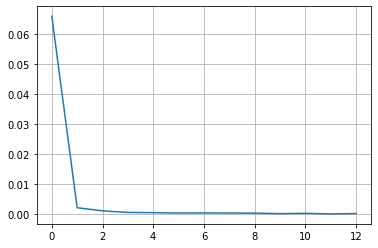

In [27]:
from scipy.fft import fftfreq
# Number of sample points
N = 25
# sample spacing
T = 1.0 / 100.0
x = np.linspace(0.0, N*T, N, endpoint=False)
trimmed_yf = train[100][0][0]
xf = fftfreq(N, T)[:N//2+1]
plt.plot( 2.0/N * trimmed_yf[0])
plt.grid()
plt.show()

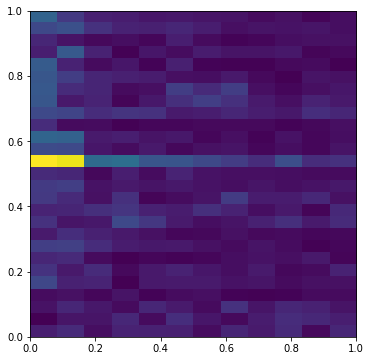

In [28]:
fig1 = plt.figure(figsize = (12,6))
ax1 = fig1.gca()
ax1.imshow(trimmed_yf[:, 1:], extent=[0, 1, 0, 1]) # not plotting 0 term

## Next up - Training!